# Part of Lab-Sheet 9 (COM3502-4502-6502 Speech Processing)

##  LPC Synthesis

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/LPC/lpc_synthesis.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

## Navigation

![LPC Synthesis is needed for LPC](images/flow_lpc_synthesis.svg)

This Lab Sheet contains several Notebooks (the blue-ish colour in the picture above indicates **this** Notebook to help with navigation):

* The Notebooks [`correlation.ipynb`](./correlation.ipynb),  [`autocorrelation.ipynb`](./LPC/autocorrelation.ipynb) and [`fundamental_frequency.ipynb`](./fundamental_frequency.ipynb)  repeat knowlege already known from lab sheet [Lab-Sheet 3](Lab-Sheet-3.ipynb) and [Lab-Sheet 7](Lab-Sheet-7.ipynb), respectively.
* The Notebook [`lpc_analysis.ipynb`](./lpc_analysis.ipynb)
* The Notebook [`lpc_synthesis.ipynb`](./lpc_synthesis.ipynb)
* The Notebook [`lpc.ipynb`](./lpc.ipynb) is the main Notebook relying an all other Notebooks and the code therein.

## Intended Learning Outcomes (ILOs)

After completing this notebook, students should be able to

- *implement* the root mean square and *recognize* its use for a signal's energy,
- *implement* a function to generate a synthetic excitation signal, and
- *implement* LPC synthesis which uses the previous functions.

In [3]:
import numpy as np

# We will use the linear filter function from scipy
from scipy.signal import lfilter

## Root Mean Square

For the LPC synthesis we will need to create impulse and/or noise signals. See the following picture (which you should have already seen in the [main lpc notebook](./lpc.ipynb)) for the source-filter model.

![The source-filter model for speech synthesis](images/source_filter_model.svg)

To ensure that the created signals have the same energies we will need to compute the *root mean square (RMS)* of a signal, which is used as an estimate for the signal's energy. The RMS is computed (as the name suggests) by taking the square root of the mean value over all squared samples:
$$RMS(s) = \sqrt{\frac{1}{L}\sum_{k=1}^L (s[k])^2}$$

**Task:** Implement the function `rms(signal)`.

In [4]:
def rms(signal):
    """Return the root mean square of data."""
    return np.sqrt(np.mean(np.square(signal)))

## Excitation Signal

For the synthesis we first need to create an excitation signal (the source part of the source-filter model).
This excitation signal consists of an impulse excitation signal mixed with a noise excitation signal (or only one of those two).

The impulse excitation signal just repeats a `1` after the given amount of samples, all other samples are `0`. The noise excitation is just white noise. The two signals are then mixed according to the given percentage. Note, that before mixing the two signals we ensure that both signals have the same energy by amplifying/reducing one of the signals according to their `rms` values.

Our parameters to the function are:

- `excitation_period`: The number of samples after which the impulse excitation signal should be repeated.
- `length`: How many samples should the generated signal have.
- `offset`: Which sample should be the first to be set to 1 in the impulse signal.
- `noise_excitation_percentage`: The percentage of the noise signal in the result (0 = pure impulse signal, 1 = pure noise signal).

In [5]:
def excitation_signal(
    excitation_period, length, offset=0, noise_excitation_percentage=0
):
    """Create excitation signal.

    - excitation_period: period of the impulse excitation in samples
    - length: length of the signal
    - offset: offset for the start of the excitation period
    - noise_excitation_percentage: percentage of the noise signal (0 = only impulse, 1= only noise)"""

    # Create a signal which is zero except for every excitation_period-th sample
    impulse = np.zeros(length)
    impulse[offset::excitation_period] = 1

    # Create a noise signal from random data (white noise)
    noise = np.random.normal(size=length)

    # Amplify / Reduce noise signal s.t. the energies of the impulse and noise signal are equal
    noise *= rms(impulse) / rms(noise)

    # Return a mixture of the impulse and noise signals according to the noise_excitation_percentage
    return (
        1 - noise_excitation_percentage
    ) * impulse + noise_excitation_percentage * noise

To illustrate the generated excitation signals we will plot an impulse-only signal, a noise-only signal and two mixed signals with different percentages.

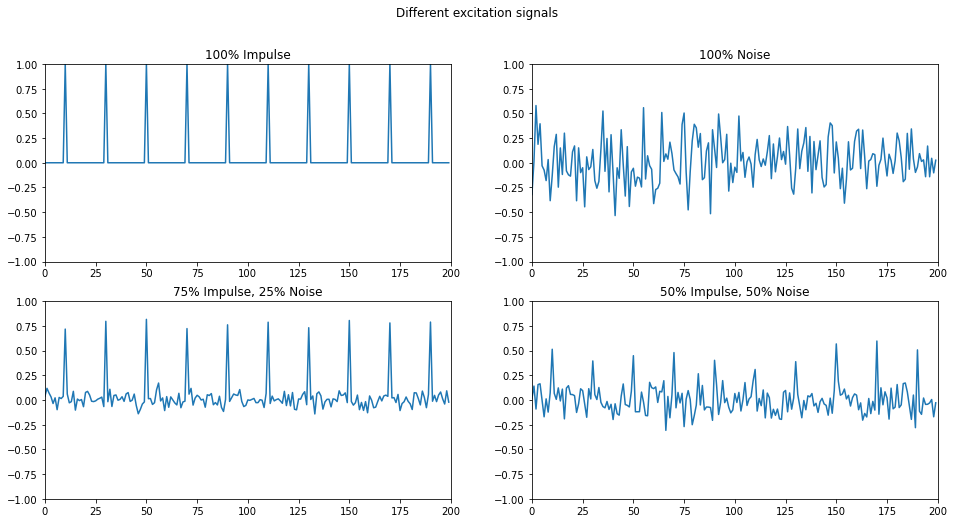

In [6]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    excitation_period = 20
    length = 200
    offset = 10

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    fig.suptitle("Different excitation signals")

    impulse_only = excitation_signal(excitation_period, length, offset, 0)
    axs[0, 0].plot(impulse_only)
    axs[0, 0].set_title("100% Impulse")
    axs[0, 0].set_xlim(0, length)
    axs[0, 0].set_ylim(-1, 1)

    noise_only = excitation_signal(excitation_period, length, offset, 1)
    axs[0, 1].plot(noise_only)
    axs[0, 1].set_title("100% Noise")
    axs[0, 1].set_xlim(0, length)
    axs[0, 1].set_ylim(-1, 1)

    more_impulse = excitation_signal(excitation_period, length, offset, 0.25)
    axs[1, 0].plot(more_impulse)
    axs[1, 0].set_title("75% Impulse, 25% Noise")
    axs[1, 0].set_xlim(0, length)
    axs[1, 0].set_ylim(-1, 1)

    equal = excitation_signal(excitation_period, length, offset, 0.5)
    axs[1, 1].plot(equal)
    axs[1, 1].set_title("50% Impulse, 50% Noise")
    axs[1, 1].set_xlim(0, length)
    axs[1, 1].set_ylim(-1, 1)

## LPC Synthesis

For the LPC synthesis there are essentially two steps we need to perform:
1. Create an excitation signal $E[z]$ which is defined by the percentage of impulse and noise part and by the frequency and offset of the impulse part.
    1. To ensure that the resulting signal has the correct energy we normalize the energy/RMS of the excitation signal $E[z]$ with the passed `original_excitation_energy`.
2. Filter $E[z]$ with an all-pole filter $H_2[z] = \frac{S[z]}{E[z]} = \frac{1}{1-\sum_{p=1}^P a_pz^{-p}}$ with the given coefficients $a_p$ to obtain the resulting signal $S[z]$.

Hence, the parameters passed to our `lpc_synthesis` function are:
- `length`, how many samples should the synthesized signal have,
- `a`, the Linear Prediction coefficients,
- `original_excitation_energy`, the energy of the prediction error sequence,
- `excitation_period`, the period of the impulse part of the excitation signal,
- `offset`, the impulse offset inside the signal, and
- `noise_excitation_percentage`, how much of the excitation signal should be noise vs. impulse signal.

In [ ]:
def lpc_synthesis(
    length,
    a,
    original_excitation_energy,
    excitation_period,
    offset=0,
    noise_excitation_percentage=0,
):
    # Generate excitation signal
    excitation = excitation_signal(
        excitation_period, length, offset, noise_excitation_percentage
    )
    # Normalize excitation signal energy with the original_excitation_energy
    excitation *= original_excitation_energy / rms(excitation)
    # Filter the excitation with all pole filter 1/A
    # Attention: all pole filters are realized by passing the numpy array [1] as first and
    #            the coefficients as second parameter to lfilter. You need to ensure that both
    #            arrays have the same data type (a.dtype).
    signal = lfilter(np.ones(1, dtype=a.dtype), a, excitation)

    return signal, excitation

## Copyright
This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 
### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/)